Imports and installs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

Load data

In [2]:
df = pd.read_csv('/content/telco_customer_churn.csv')

print("✅ Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\n" + "="*50 + "\n")

# Display first few rows
print("First 5 rows:")
display(df.head())

print("\n" + "="*50 + "\n")
print("Dataset Information:")
print(df.info())

print("\n" + "="*50 + "\n")
print("Basic Statistics:")
display(df.describe())

print("\n" + "="*50 + "\n")
print("Missing Values:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

# Check for empty spaces (common issue in this dataset)
print("\nChecking for empty strings...")
for col in df.columns:
    if df[col].dtype == 'object':
        empty_count = (df[col] == ' ').sum() + (df[col] == '').sum()
        if empty_count > 0:
            print(f"{col}: {empty_count} empty values")

# Fix the TotalCharges column (has empty strings)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(f"\nTotalCharges missing after conversion: {df['TotalCharges'].isnull().sum()}")

# Fill missing TotalCharges with 0 (for customers with tenure 0)
df['TotalCharges'].fillna(0, inplace=True)

# Check class distribution
print("\n" + "="*50 + "\n")
print("Class Distribution (Churn):")
churn_dist = df['Churn'].value_counts()
print(churn_dist)
print(f"\nChurn Rate: {(churn_dist['Yes']/len(df))*100:.2f}%")

✅ Dataset loaded successfully!
Dataset shape: (7043, 21)


First 5 rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes




Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000




Missing Values:
Series([], dtype: int64)

Checking for empty strings...
TotalCharges: 11 empty values

TotalCharges missing after conversion: 11


Class Distribution (Churn):
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Rate: 26.54%


Exploratory data analysis

Missing Values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

TARGET DISTRIBUTION
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Percentage:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


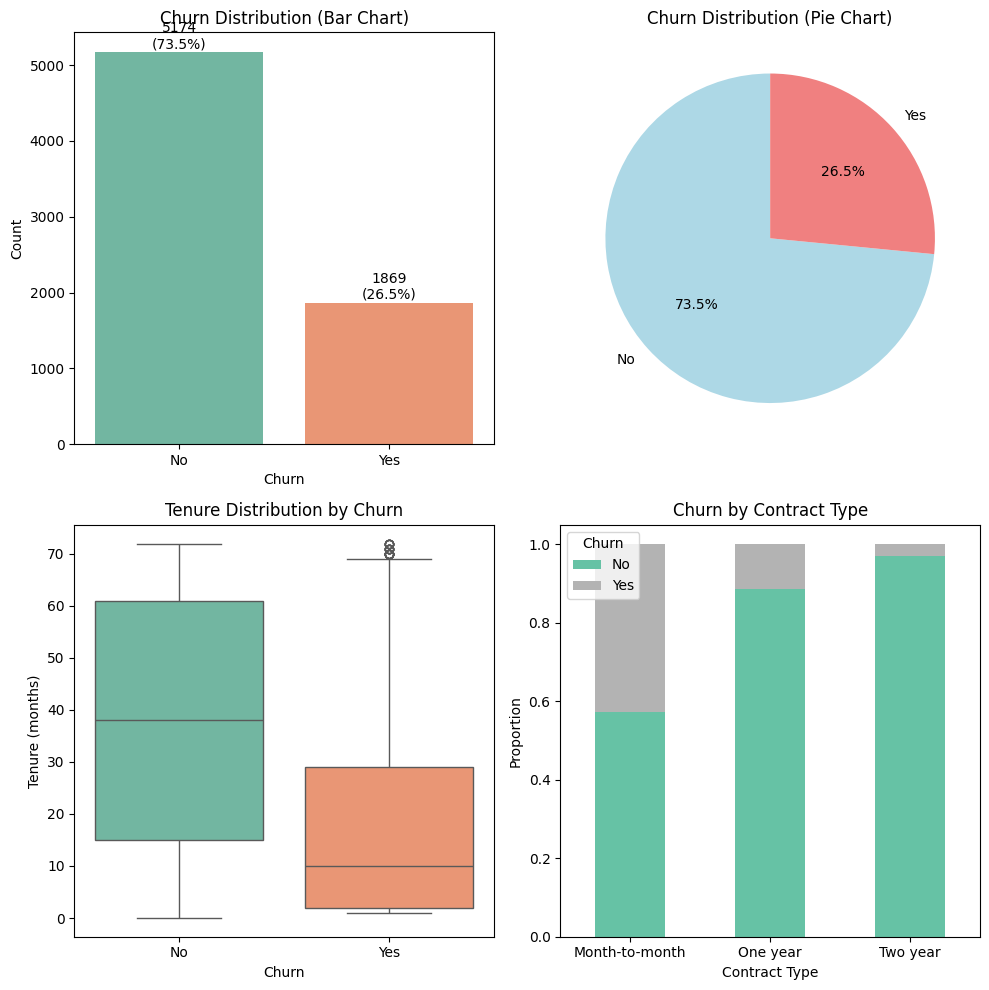


CORRELATION ANALYSIS


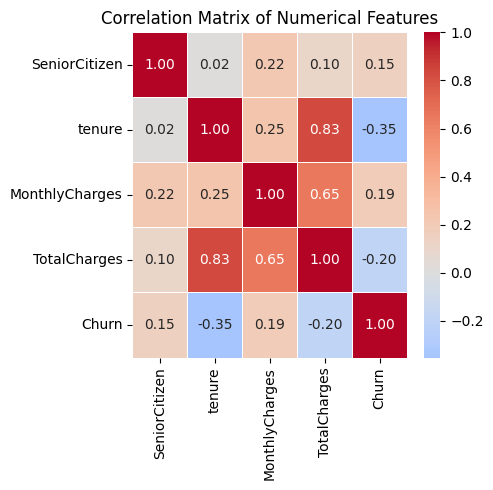

✅ EDA completed with 5 essential visualizations:
1. Churn Distribution (Bar Chart)
2. Churn Distribution (Pie Chart)
3. Tenure vs Churn
4. Contract vs Churn
5. Correlation Matrix


In [9]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Handle TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

# Target distribution
print("\n" + "="*50)
print("TARGET DISTRIBUTION")
print("="*50)
churn_counts = df['Churn'].value_counts()
churn_percent = df['Churn'].value_counts(normalize=True) * 100
print(churn_counts)
print(f"\nPercentage:\n{churn_percent}")

# Create figure with 2 rows, 2 columns
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# 1. Churn Distribution (Bar Chart)
sns.countplot(x='Churn', data=df, palette='Set2', ax=axes[0, 0])
axes[0, 0].set_title('Churn Distribution (Bar Chart)')
axes[0, 0].set_xlabel('Churn')
axes[0, 0].set_ylabel('Count')
for i, (count, percent) in enumerate(zip(churn_counts.values, churn_percent.values)):
    axes[0, 0].text(i, count + 50, f'{count}\n({percent:.1f}%)', ha='center')

# 2. Churn Distribution (Pie Chart)
axes[0, 1].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%',
               colors=['lightblue', 'lightcoral'], startangle=90)
axes[0, 1].set_title('Churn Distribution (Pie Chart)')

# 3. Tenure vs Churn (Box Plot)
sns.boxplot(x='Churn', y='tenure', data=df, ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('Tenure Distribution by Churn')
axes[1, 0].set_xlabel('Churn')
axes[1, 0].set_ylabel('Tenure (months)')

# 4. Contract vs Churn (Stacked Bar)
contract_churn = df.groupby('Contract')['Churn'].value_counts(normalize=True).unstack()
contract_churn.plot(kind='bar', stacked=True, ax=axes[1, 1], colormap='Set2')
axes[1, 1].set_title('Churn by Contract Type')
axes[1, 1].set_xlabel('Contract Type')
axes[1, 1].set_ylabel('Proportion')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# 5. Correlation Matrix (separate figure)
print("\n" + "="*50)
print("CORRELATION ANALYSIS")
print("="*50)

df_numeric = df.copy()
df_numeric['Churn'] = df_numeric['Churn'].map({'No': 0, 'Yes': 1})
df_numeric['SeniorCitizen'] = df_numeric['SeniorCitizen'].astype(int)
numeric_for_corr = df_numeric.select_dtypes(include=[np.number])

plt.figure(figsize=(5, 5))
sns.heatmap(numeric_for_corr.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

print("✅ EDA completed with 5 essential visualizations:")
print("1. Churn Distribution (Bar Chart)")
print("2. Churn Distribution (Pie Chart)")
print("3. Tenure vs Churn")
print("4. Contract vs Churn")
print("5. Correlation Matrix")